### Read files

In [1]:
import glob, re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import *

data = {
    #visitors
    'tra': pd.read_csv('./input/air_visit_data.csv',parse_dates=["visit_date"]),
    #reservations
    'ar': pd.read_csv('./input/air_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    'hr': pd.read_csv('./input/hpg_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    #store info
    'as': pd.read_csv('./input/air_store_info.csv'),
    'hs': pd.read_csv('./input/hpg_store_info.csv'),
    #air<->hpg
    'id': pd.read_csv('./input/store_id_relation.csv'),
    #days
    'hol': pd.read_csv('./input/date_info.csv',parse_dates=["calendar_date"]), #.rename(columns={'calendar_date':'visit_date'})
    #
    'tes': pd.read_csv('./input/sample_submission.csv'),
    }

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions a

In [2]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(np.log(y+1), np.log(pred+1))**0.5
def RMSE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

### Some data categorizing to reduce space

In [3]:
import sys
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hs 1.3301172256469727
hr 192.67313385009766
id 0.022129058837890625
tes 2.9315261840820312
as 0.23502159118652344
hol 0.039612770080566406
tra 4.38869571685791
ar 8.898050308227539
total 210.5182867050171


In [4]:
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
data["as"]["air_store_id"]=data["as"]["air_store_id"].astype('category')
data["as"]["air_genre_name"]=data["as"]["air_genre_name"].astype('category')
data["as"]["air_area_name"]=data["as"]["air_area_name"].astype('category')
data["hs"]["hpg_store_id"]=data["hs"]["hpg_store_id"].astype('category')
data["hs"]["hpg_genre_name"]=data["hs"]["hpg_genre_name"].astype('category')
data["hs"]["hpg_area_name"]=data["hs"]["hpg_area_name"].astype('category')
data["ar"]["air_store_id"]=data["ar"]["air_store_id"].astype('category')
data["hr"]["hpg_store_id"]=data["hr"]["hpg_store_id"].astype('category')
data["id"]["hpg_store_id"]=data["id"]["hpg_store_id"].astype('category')
data["id"]["air_store_id"]=data["id"]["air_store_id"].astype('category')
data["hol"]["day_of_week"]=data["hol"]["day_of_week"].astype('category')
data["hol"]["holiday_flg"]=data["hol"]["holiday_flg"].astype('category')

In [5]:
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hs 0.45134544372558594
hr 50.57759189605713
id 0.022701263427734375
tes 2.9315261840820312
as 0.09117889404296875
hol 0.005473136901855469
tra 4.38869571685791
ar 2.313718795776367
total 60.78223133087158


In [6]:
data["tra"]["visitors"]=np.log1p(data["tra"]["visitors"])
data["tra"].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,3.258097
1,air_ba937bf13d40fb24,2016-01-14,3.496508
2,air_ba937bf13d40fb24,2016-01-15,3.401197
3,air_ba937bf13d40fb24,2016-01-16,3.135494
4,air_ba937bf13d40fb24,2016-01-18,1.945910


### test

In [7]:
data["tes"][["store_id","time"]]=data["tes"]["id"].str.split("_2017",expand=True)
data["tes"]["time"]="2017"+data["tes"]["time"]
from dateutil import parser
data["tes"]["time"] = pd.to_datetime(data["tes"]["time"])
#data["tes"]["kind"]=data["tes"]["id"].str.split("_",expand=True)[0] #they are all air type

In [8]:
print(data["tes"].dtypes)
#data["tes"].head(5)

id                  object
visitors             int64
store_id            object
time        datetime64[ns]
dtype: object


I add the test dates/stores to the train df

In [9]:
print(len(data["tra"]))

252108


In [10]:
data["tra"]
test_dates=data["tes"]["time"].unique()
test_stores=data["tes"]["store_id"].unique()

days = pd.DataFrame({'visit_date':test_dates})
stores = pd.DataFrame({'air_store_id':test_stores})
stores['key'] = 0
days['key'] = 0
days_and_stores = days.merge(stores, how='left', on = 'key')
days_and_stores.drop('key',1, inplace=True)
days_and_stores

data["tra"]=data["tra"].append(days_and_stores)

In [11]:
print(len(days_and_stores))
print(len(data["tra"]))
#data["tra"]

32019
284127


### Analysis

Join dataframes 

In [12]:
data["tra_hol"]=data["tra"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
            drop("calendar_date",axis=1)
data["tra_hol"].head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,3.091042,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,3.713572,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,1.791759,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,2.944439,Wednesday,0


In [13]:
store_mean_0=pd.DataFrame()
store_mean_0["mean"]=data["tra"].groupby("air_store_id").visitors.mean()
store_mean_0["median"]=data["tra"].groupby("air_store_id").visitors.median()
store_mean_0["min"]=data["tra"].groupby("air_store_id").visitors.min()
store_mean_0["max"]=data["tra"].groupby("air_store_id").visitors.max()
store_mean_0["std"]=data["tra"].groupby("air_store_id").visitors.std()
store_mean_0.head()


,mean,median,min,max,std
air_store_id,,,,,
air_00a91d42b08b08d9,3.167414,3.295837,0.693147,4.605170,0.576968
air_0164b9927d20bcc3,2.117522,2.197225,0.693147,3.332205,0.685494
air_0241aa3964b7f861,2.236649,2.302585,0.693147,3.891820,0.565187
air_0328696196e46f18,1.966041,1.945910,0.693147,3.737670,0.662686
air_034a3d5b40d5b1b1,2.457141,2.564949,0.693147,4.762174,0.823890


In [61]:
store_mean_dow=pd.DataFrame()
store_mean_dow["visitors_dow_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.median() #.reset_index()
store_mean_dow["visitors_dow_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.mean() #.reset_index()
store_mean_dow["visitors_dow_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.min() #.reset_index()
store_mean_dow["visitors_dow_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.max() #.reset_index()
store_mean_dow["visitors_dow_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.std() #.reset_index()
store_mean_dow["visitors_dow_mdn"].fillna(store_mean_0["median"],inplace=True)
store_mean_dow["visitors_dow_mean"].fillna(store_mean_0["mean"],inplace=True)
store_mean_dow["visitors_dow_min"].fillna(store_mean_0["min"],inplace=True)
store_mean_dow["visitors_dow_max"].fillna(store_mean_0["max"],inplace=True)
store_mean_dow["visitors_dow_std"].fillna(store_mean_0["std"],inplace=True)
store_mean_dow.fillna(0,inplace=True)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow=store_mean_dow.reset_index() #unstack(level=1)
store_mean_dow.head()

,air_store_id,day_of_week,visitors_dow_mdn,visitors_dow_mean,visitors_dow_min,visitors_dow_max,visitors_dow_std
0,air_00a91d42b08b08d9,Friday,3.597218,3.595110,2.890372,4.060443,0.249142
1,air_00a91d42b08b08d9,Monday,2.995732,3.056744,0.693147,3.871201,0.522171
2,air_00a91d42b08b08d9,Saturday,2.484907,2.505629,1.386294,4.605170,0.665186
3,air_00a91d42b08b08d9,Sunday,1.098612,1.098612,1.098612,1.098612,0.000000
4,air_00a91d42b08b08d9,Thursday,3.433987,3.401823,2.772589,3.871201,0.244663


In [68]:
store_mean_dow_hol=pd.DataFrame()
store_mean_dow_hol["visitors_dow_hol_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.median() #.reset_index()
store_mean_dow_hol["visitors_dow_hol_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.mean() #.reset_index()
store_mean_dow_hol["visitors_dow_hol_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.min() #.reset_index()
store_mean_dow_hol["visitors_dow_hol_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.max() #.reset_index()
store_mean_dow_hol["visitors_dow_hol_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.std() #.reset_index()
store_mean_dow_hol["visitors_dow_hol_mdn"].fillna(store_mean_dow["visitors_dow_mdn"],inplace=True)
store_mean_dow_hol["visitors_dow_hol_mean"].fillna(store_mean_dow["visitors_dow_mean"],inplace=True)
store_mean_dow_hol["visitors_dow_hol_min"].fillna(store_mean_dow["visitors_dow_min"],inplace=True)
store_mean_dow_hol["visitors_dow_hol_max"].fillna(store_mean_dow["visitors_dow_max"],inplace=True)
store_mean_dow_hol["visitors_dow_hol_std"].fillna(store_mean_dow["visitors_dow_std"],inplace=True)
store_mean_dow_hol=store_mean_dow_hol.fillna(0)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow_hol=store_mean_dow_hol.reset_index() #unstack(level=1)
store_mean_dow_hol.head()

,air_store_id,day_of_week,holiday_flg,visitors_dow_hol_mdn,visitors_dow_hol_mean,visitors_dow_hol_min,visitors_dow_hol_max,visitors_dow_hol_std
0,air_00a91d42b08b08d9,Friday,0,3.597218,3.595110,2.890372,4.060443,0.249142
1,air_00a91d42b08b08d9,Friday,1,0.000000,0.000000,0.000000,0.000000,0.000000
2,air_00a91d42b08b08d9,Monday,0,2.995732,3.055735,0.693147,3.871201,0.529989
3,air_00a91d42b08b08d9,Monday,1,3.091042,3.091042,3.091042,3.091042,0.000000
4,air_00a91d42b08b08d9,Saturday,0,2.484907,2.505629,1.386294,4.605170,0.665186


In [69]:
data["tra"]["month"]=data["tra"].visit_date.map(lambda x: x.month)
data["tra"]["month"]=data["tra"]["month"].astype('category')

In [70]:
data["tra_as_hol"]=data["tra"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
            drop("calendar_date",axis=1).\
            merge(store_mean_dow,on=["air_store_id","day_of_week"]).\
            merge(store_mean_dow_hol,on=["air_store_id","day_of_week",'holiday_flg']).\
            merge(data["as"],on=["air_store_id"]).\
            merge(store_mean_0,left_on=["air_store_id"],right_index=True)
            



In [71]:
data["tra_as_hol"]["time_numeric"]=pd.to_numeric(data["tra_as_hol"].visit_date-data["tra_as_hol"].visit_date.min())/100000
#data["tra_as_hol"]["time_numeric"].describe()
data["tra_as_hol"].head()
#data["tra_as_hol"].tail()

,air_store_id,visit_date,visitors,month,day_of_week,holiday_flg,visitors_dow_mdn,visitors_dow_mean,visitors_dow_min,visitors_dow_max,...,air_genre_name,air_area_name,latitude,longitude,mean,median,min,max,std,time_numeric
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1,Wednesday,0,3.258097,3.137813,2.079442,4.060443,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3.014389,3.135494,0.693147,4.127134,0.616634,1.036800e+10
1,air_ba937bf13d40fb24,2016-01-20,3.465736,1,Wednesday,0,3.258097,3.137813,2.079442,4.060443,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3.014389,3.135494,0.693147,4.127134,0.616634,1.641600e+10
2,air_ba937bf13d40fb24,2016-01-27,3.218876,1,Wednesday,0,3.258097,3.137813,2.079442,4.060443,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3.014389,3.135494,0.693147,4.127134,0.616634,2.246400e+10
3,air_ba937bf13d40fb24,2016-02-03,2.944439,2,Wednesday,0,3.258097,3.137813,2.079442,4.060443,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3.014389,3.135494,0.693147,4.127134,0.616634,2.851200e+10
4,air_ba937bf13d40fb24,2016-02-10,3.496508,2,Wednesday,0,3.258097,3.137813,2.079442,4.060443,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3.014389,3.135494,0.693147,4.127134,0.616634,3.456000e+10


One-hot encoding for day of week, holiday, month, genre, area

In [72]:
data["tra_as_hol"]["month"]=data["tra_as_hol"]["month"].astype('category')
#data["tra_as_hol"].dtypes
cols_to_enc=["month","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["latitude","longitude"],axis=1)
enc.head()
#for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)



156


Binary encoder

In [73]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc2=encoder.fit_transform(data["tra_as_hol"])

In [74]:
'''def f64_to_32(df):
    float_cols=df.select_dtypes(include=["float64"]).columns
    int_cols=df.select_dtypes(include=["int64"]).columns
    for fc in float_cols:
        print(fc)
        df[fc]=df[fc].astype("float32")
    for ic in int_cols:
        print(ic)
        df[ic]=df[ic].astype("int32")
 
f64_to_32(enc)
f64_to_32(enc2)
#enc.dtypes''';

Divide train-test before-after

In [75]:
cut_date='2017-3-1'

def train_test_eval(df,cut_date):
    df_train=df[df.visitors.notnull()][df["visit_date"]<cut_date]        #train
    df_test= df[df.visitors.notnull()][df["visit_date"]>= cut_date]      #test (I have data to check)
    df_eval= df[df.visitors.isnull()]                                   #eval (for submission only, no data to check)
    return(df_train,df_test,df_eval)
    
df_train,df_test,df_eval=train_test_eval(enc,cut_date)

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


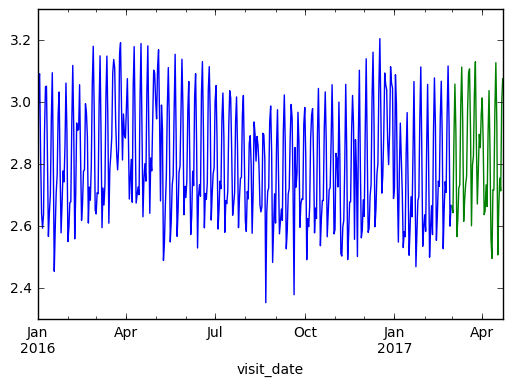

In [76]:
%matplotlib inline
df_train.groupby("visit_date")["visitors"].mean().plot()
df_test.groupby("visit_date")["visitors"].mean().plot()

In [77]:
print(
len(data["tra_as_hol"]["air_area_name"].unique()),
len(data["tra_as_hol"]["longitude"].unique()),
len(data["tra_as_hol"]["latitude"].unique()),
)
print(
len(data["tra_as_hol"].groupby(['latitude', 'longitude']).size()),
len(data["tra_as_hol"].groupby(["air_area_name",'latitude', 'longitude']).size())
)

103 108 108
108 108


For each store I use mean, min, max, std, area, genre, day and holiday as predictors

In [78]:


df_train.head()

,air_store_id,visit_date,visitors,holiday_flg,visitors_dow_mdn,visitors_dow_mean,visitors_dow_min,visitors_dow_max,visitors_dow_std,visitors_dow_hol_mdn,...,air_area_name_Ōsaka-fu Sakai-shi Minamikawaramachi,air_area_name_Ōsaka-fu Suita-shi Izumichō,air_area_name_Ōsaka-fu Ōsaka-shi Fuminosato,air_area_name_Ōsaka-fu Ōsaka-shi Kyōmachibori,air_area_name_Ōsaka-fu Ōsaka-shi Kyūtarōmachi,air_area_name_Ōsaka-fu Ōsaka-shi Nakanochō,air_area_name_Ōsaka-fu Ōsaka-shi Nanbasennichimae,air_area_name_Ōsaka-fu Ōsaka-shi Shinmachi,air_area_name_Ōsaka-fu Ōsaka-shi Ōgimachi,air_area_name_Ōsaka-fu Ōsaka-shi Ōhiraki
0,air_ba937bf13d40fb24,2016-01-13,3.258097,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-20,3.465736,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-27,3.218876,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-02-03,2.944439,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0
4,air_ba937bf13d40fb24,2016-02-10,3.496508,0,3.258097,3.137813,2.079442,4.060443,0.406326,3.258097,...,0,0,0,0,0,0,0,0,0,0


In [79]:
def xy_train_test(df_train,df_test):
    try:
        X_train = df_train.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
        X_test =  df_test.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    except:
        #try:
            X_train = df_train.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
            X_test =  df_test.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
        #except: 
        #            try:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #            except:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()"""
    # Split the targets into training/testing sets
    try:
        y_train = df_train["visitors"].values
        y_test =  df_test["visitors"].values
    except:
        y_train = df_train["col_visitors"].values
        y_test =  df_test["col_visitors"].values
        
    #return(X_train,X_test,y_train,y_test)              
    return(X_train.astype("float32"),X_test.astype("float32"),y_train.astype("float32"),y_test.astype("float32"))              


def test(df_train,df_test,regr):
    #print(df_train.columns)

    (X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

    #print(X_train.shape,y_train.shape)
    #print(X_test.shape,y_test.shape)
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred_train=np.maximum(0,y_pred_train)
    error=RMSE(y_test, y_pred)
    error_train=RMSE(y_train, y_pred_train)
    print(error,error_train)
    return error,error_train

In [80]:
(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

In [81]:
df_train,df_test,df_eval=train_test_eval(enc,cut_date)
test(df_train,df_test, linear_model.LinearRegression())
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
test(df_train,df_test, linear_model.LinearRegression())

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.830475009956 0.803764814237
0.83047497407 0.803764814237


(0.83047497406975024, 0.80376481423734114)

In [82]:
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc2=encoder.fit_transform(data["tra_as_hol"])

In [83]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
#df_train,df_test,df_eval=train_test_eval(enc,cut_date)

test(df_train,df_test, linear_model.LinearRegression())
test(df_train,df_test, linear_model.Ridge(alpha=0.001))
test(df_train,df_test, linear_model.Ridge(alpha=0.01))
test(df_train,df_test, linear_model.Ridge(alpha=0.1))
test(df_train,df_test, linear_model.Ridge(alpha=1))
test(df_train,df_test, linear_model.Ridge(alpha=10))
test(df_train,df_test, linear_model.Ridge(alpha=100))
test(df_train,df_test, linear_model.Ridge(alpha=1000))
#test(df_train,df_test, linear_model.Lasso(alpha=0.01))

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.83047497407 0.803764814237
0.507066589676 0.502605177989
0.507066560289 0.502605177989
0.507066589676 0.502605177989
0.507066295806 0.502605207637
0.507064121162 0.502606482492
0.507052865765 0.502657770517
0.507275106276 0.503273559341


(0.50727510627593941, 0.5032735593410097)

In [97]:



#test(df_train,df_test, svm.SVR(C=0.01))
#test(df_train,df_test, svm.SVR(C=0.1))
#test(df_train,df_test, svm.SVR(C=1))
#test(df_train,df_test, svm.SVR(C=10))
#test(df_train,df_test, svm.SVR(C=100))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=5,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.AdaBoostRegressor)
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=10))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=17))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=120,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=18))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=12))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=180,max_features="log2",max_depth=10))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=500,max_features="log2",max_depth=15))


0.519755399864 0.432441759759


(0.51975539986388819, 0.43244175975916832)

In [85]:
from sklearn.model_selection import PredefinedSplit
test_fold=np.append(-np.ones(len(df_train)),np.zeros(len(df_test)))
ps = PredefinedSplit(test_fold)
ps.get_n_splits()
print(ps)       
for train_index, test_index in ps.split():
    print(len(train_index),len(test_index))
    print(len(df_train),len(df_test))
    print(train_index,test_index)


PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))
214046 38062
214046 38062
[     0      1      2 ..., 214043 214044 214045] [214046 214047 214048 ..., 252105 252106 252107]


In [90]:
import scipy
from  sklearn.model_selection import RandomizedSearchCV
grid=RandomizedSearchCV(ensemble.RandomForestRegressor(), 
                                        param_distributions=
                        {"max_depth": scipy.stats.randint(5,20), 
                         'n_estimators': scipy.stats.randint(50,250),
                        'max_features':('log2','sqrt')},
                                        n_iter=10,verbose=10,cv=ps,scoring="neg_mean_squared_error" )

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)
X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)

grid.fit(X_tot,y_tot)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] max_depth=10, max_features=sqrt, n_estimators=123 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=123, score=-0.26342826471355113, total=  19.6s
[CV] max_depth=16, max_features=sqrt, n_estimators=69 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s remaining:    0.0s


[CV]  max_depth=16, max_features=sqrt, n_estimators=69, score=-0.2719819344591799, total=  15.7s
[CV] max_depth=10, max_features=log2, n_estimators=189 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.4s remaining:    0.0s


[CV]  max_depth=10, max_features=log2, n_estimators=189, score=-0.2642754064753766, total=  31.0s
[CV] max_depth=16, max_features=log2, n_estimators=249 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=16, max_features=log2, n_estimators=249, score=-0.2698279749031835, total=  55.0s
[CV] max_depth=5, max_features=sqrt, n_estimators=63 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


[CV]  max_depth=5, max_features=sqrt, n_estimators=63, score=-0.26392152617051884, total=   6.4s
[CV] max_depth=7, max_features=log2, n_estimators=150 ................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s


[CV]  max_depth=7, max_features=log2, n_estimators=150, score=-0.26145786798880316, total=  19.1s
[CV] max_depth=11, max_features=sqrt, n_estimators=239 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV]  max_depth=11, max_features=sqrt, n_estimators=239, score=-0.26439749489821, total=  39.2s
[CV] max_depth=8, max_features=log2, n_estimators=152 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.3min remaining:    0.0s


[CV]  max_depth=8, max_features=log2, n_estimators=152, score=-0.261956309804004, total=  21.1s
[CV] max_depth=12, max_features=log2, n_estimators=57 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s


[CV]  max_depth=12, max_features=log2, n_estimators=57, score=-0.2661620145506261, total=  10.4s
[CV] max_depth=16, max_features=log2, n_estimators=110 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.8min remaining:    0.0s


[CV]  max_depth=16, max_features=log2, n_estimators=110, score=-0.2707930452427361, total=  24.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe40fa13b70>, 'max_features': ('log2', 'sqrt'), 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe40fa3e588>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=10)

In [92]:
grid.best_score_,np.sqrt(-grid.best_score_),grid.best_params_

(-0.26145786798880316,
 0.51132951018770978,
 {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 150})

In [ ]:
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=5))
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=5))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=10))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=10))
#test(df_train,df_test,ensemble.AdaBoostRegressor(n_estimators=100, learning_rate=0.5, loss="square"))

In [ ]:
from xgboost import XGBRegressor
for rate in 0.1,:
    print(rate)
    test(df_train,df_test,XGBRegressor(max_depth=10, learning_rate=rate, n_estimators=50))

In [ ]:
ps = PredefinedSplit(test_fold=your_test_fold)

In [ ]:
def lognuniform(low=0, high=1, size=None, base=10):
    return np.power(base, np.random.uniform(low, high, size))

In [ ]:
a=lognuniform(low=-4,high=0,size=10,base=10)
a

In [ ]:
import scipy


grid=model_selection.RandomizedSearchCV(XGBRegressor(), 
                                        param_distributions={
                        "max_depth": scipy.stats.randint(2,10), 
                         'n_estimators': scipy.stats.randint(50,400),
                         'learning_rate':lognuniform(low=-1.5,high=-0.5,base=10,size=100),
                        }, 
                                        n_iter=100,verbose=10 ,cv=ps,scoring="neg_mean_squared_error")

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)


grid.fit(X_tot,y_tot)

In [ ]:
np.sqrt(-grid.best_score_),grid.best_params_

In [ ]:
test(df_train,df_test,XGBRegressor(learning_rate=0.1, n_estimators=89,max_depth=5))


In [ ]:
"""
for fct in (ce.BinaryEncoder,ce.HashingEncoder,\
                ce.OneHotEncoder,ce.OrdinalEncoder,ce.PolynomialEncoder,\
                ce.BaseNEncoder,ce.LeaveOneOutEncoder):
    print(fct)
    encoder=fct(cols=cols_to_enc)
    enc=encoder.fit_transform(data["tra_as_hol"])
    df_train,df_test,df_eval=train_test_eval(enc,cut_date)
    test(df_train,df_test, linear_model.LinearRegression())

    
   
ce.BackwardDifferenceEncoder(cols=[...])
ce.BinaryEncoder(cols=[...])
ce.HashingEncoder(cols=[...])
ce.HelmertEncoder(cols=[...])
ce.OneHotEncoder(cols=[...])
ce.OrdinalEncoder(cols=[...])
ce.SumEncoder(cols=[...])
ce.PolynomialEncoder(cols=[...])
ce.BaseNEncoder(cols=[...])
ce.LeaveOneOutEncoder(cols=[...])
"""

## For submission

In [ ]:
df_eval

In [94]:
def make_csv(df_train,df_test,df_eval,regr,file):
    df_train_tot=df_train.append(df_test)
    print(df_train_tot.columns)
    print(df_eval.columns)
    X_train = df_train_tot.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    X_test =  df_eval.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    # Split the targets into training/testing sets
    y_train = df_train_tot["visitors"].values
    print(X_train.shape,y_train.shape)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred=np.expm1(y_pred)
    df_eval["visitors"]=y_pred
    df_eval["id"]=df_eval["air_store_id"].map(str)+"_"+df_eval["visit_date"].dt.strftime('%Y-%m-%d')
    df_sub=df_eval[["id","visitors"]]
    df_sub.to_csv(file,index=False)

In [ ]:
df_eval=enc[enc.visitors.isna()]  
make_csv(df_train,df_test,df_eval,linear_model.LinearRegression(),"linear_binary.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=18),
         "random_f_binary_log.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,XGBRegressor(learning_rate=0.12, n_estimators=300,max_depth=2),
         "xgb_new.csv")

In [96]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16),
         "forest.csv")
#df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
#make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=7),
#         "forest.csv")

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Index(['month_0', 'month_1', 'month_2', 'month_3', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'air_genre_name_0',
       'air_genre_name_1', 'air_genre_name_2', 'air_genre_name_3',
       'air_area_name_0', 'air_area_name_1', 'air_area_name_2',
       'air_area_name_3', 'air_area_name_4', 'air_area_name_5',
       'air_area_name_6', 'air_store_id', 'visit_date', 'visitors',
       'holiday_flg', 'visitors_dow_mdn', 'visitors_dow_mean',
       'visitors_dow_min', 'visitors_dow_max', 'visitors_dow_std',
       'visitors_dow_hol_mdn', 'visitors_dow_hol_mean', 'visitors_dow_hol_min',
       'visitors_dow_hol_max', 'visitors_dow_hol_std', 'latitude', 'longitude',
       'mean', 'median', 'min', 'max', 'std', 'time_numeric'],
      dtype='object')
Index(['month_0', 'month_1', 'month_2', 'month_3', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'air_genre_name_0',
       'air_genre_name_1', 'air_genre_name_2', 'air_genre_name_3',
       'air_area_name_0', 'air_area_n

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
df_test=data["tes"].merge(data["hol"],left_on="time",right_on="calendar_date").\
            drop("time",axis=1).\
            merge(data["as"],right_on="air_store_id",left_on="store_id").\
            drop(["store_id"],axis=1)

In [ ]:
df_test

In [ ]:
df_test["month"]=df_test.calendar_date.map(lambda x: x.month)
df_test["month"]=df_test["month"].astype('category')

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(df_test[cols_to_enc])
#data["tra_as_hol"].join(dummies)
df_test=df_test.join(dummies)
#enc.describe()
df_test=df_test.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in df_test.columns: print(c)
print(len(df_test.columns))

In [ ]:
df_train

### reservations

In [ ]:
#total number of reservations per day, for a stores
data["ar"]["visit_date"]=data["ar"]["visit_datetime"].map(lambda x:x.date())
data["ar"]["visit_date"]=pd.to_datetime(data["ar"]["visit_date"])
#data["ar"].groupby("air_store_id","visit_date")["reserve_visitors"].sum()

#data["ar"]
data["ar_sum"]=data["ar"].groupby(["air_store_id","visit_date"]) ["reserve_visitors"].sum().reset_index()
data["ar_sum"].head()

In [ ]:
#this contains only days with reservations
data["tra_ar_sum"]=data["ar_sum"].merge(data["tra_as_hol"],on=["visit_date","air_store_id"])
data["tra_ar_sum"].head()
df_train

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)
df_train=enc[enc["visit_date"]<cut_date]
df_test= enc[enc["visit_date"]>= cut_date]

In [ ]:
from sklearn import *
print(df_train.columns)
X_train = df_train.drop(["visitors","visit_date"],axis=1).as_matrix()
X_test =  df_test.drop(["visitors","visit_date"],axis=1).as_matrix()
    # Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred=np.maximum(0,y_pred)
error=RMSLE(y_test, y_pred)
print(error)

In [ ]:
df_store_test[["visitors","visitors_predicted"]]
df_test[["visitors","visitors_predicted"]]

In [ ]:
df_train.columns

In [ ]:
X_train = df_train.drop(["visitors","visit_date"],axis=1).values
X_test =  df_test.drop(["visitors","visit_date"],axis=1).values
# Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values

In [ ]:
y_train

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

### unique stores

In [ ]:
data["hr"]

In [ ]:
stores_tra=set(data["tra"].air_store_id.unique())
stores_ar=set(data["ar"].air_store_id.unique())
stores_hr=set(data["hr"].hpg_store_id.unique())
stores_as=set(data["as"].air_store_id.unique())
stores_hs=set(data["hs"].hpg_store_id.unique())
stores_id_a=set(data["id"].air_store_id.unique())
stores_id_h=set(data["id"].hpg_store_id.unique())
stores_tes=set(data["tes"].store_id.unique())

In [ ]:
stores_tes-stores_tra

In [ ]:
print(
    len(stores_tra),len(stores_ar),len(stores_as),len(stores_id_a),"\n",
                    len(stores_hr),len(stores_hs),len(stores_id_h),"\n",
    len(stores_tes))

In [ ]:
X_train

In [ ]:
df_train.shape,df_test.shape

### Time series

In [ ]:
data["tra_as_hol"]

In [ ]:
stores_groups=data["tra_as_hol"].groupby("air_store_id")

In [ ]:
series_test=stores_groups.get_group("air_00a91d42b08b08d9")[["visit_date","visitors"]]
series_test=series_test.set_index(series_test.visit_date).drop("visit_date",axis=1).dropna()
series_test.plot()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series_test, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
model_fit.fittedvalues.plot()
series_test.plot()

### DOW HOL average

In [ ]:
df_train,df_test,df_eval=train_test_eval(data["tra_as_hol"],cut_date)

In [ ]:
def get_y_pred(df_train,df_test):
    mean_store_dow_hol=df_train.groupby(["air_store_id","day_of_week","holiday_flg"]).visitors.mean().reset_index()
    mean_store_dow=df_train.groupby(["air_store_id","day_of_week"]).visitors.mean().reset_index()
    mean_store_hol=df_train.groupby(["air_store_id","holiday_flg"]).visitors.mean().reset_index()
    mean_store=df_train.groupby(["air_store_id"]).visitors.mean().reset_index()
    df_1=df_test.merge(mean_store_dow_hol,on=["air_store_id","day_of_week","holiday_flg"],how="left")
    df_2=df_test.merge(mean_store_hol,on=["air_store_id","holiday_flg"],how="left")
    df_3=df_test.merge(mean_store_dow,on=["air_store_id","day_of_week"],how="left")
    df_4=df_test.merge(mean_store,on=["air_store_id"],how="left")
    y_pred_1=df_1.visitors_y.values
    y_pred_2=df_2.visitors_y.values
    y_pred_3=df_3.visitors_y.values
    y_pred_4=df_4.visitors_y.values
    y_test=df_1.visitors_x.values
    for i,y in enumerate(y_pred_1):
        if np.isnan(y): 
            if not np.isnan(y_pred_2[i]): y_pred_1[i]=y_pred_2[i]
            else:
                if not np.isnan(y_pred_3[i]): y_pred_1[i]=y_pred_3[i]
                else:
                    if not np.isnan(y_pred_4[i]):y_pred_1[i]=y_pred_4[i]
                    else:y_pred_1[i]=0
    return (y_test,y_pred_1)




y_test,y_pred=get_y_pred(df_train,df_test)
y_train,y_pred_t=get_y_pred(df_train,df_train)

In [ ]:
len(y_test),len(y_pred),len(y_train),len(y_pred_t)

In [ ]:
RMSE(y_train,y_pred_t),RMSE(y_test,y_pred)